In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as colors

In [3]:
freedom_cleaned=pd.read_csv('/content/drive/MyDrive/DS LAB - Colombaro, Ferretti, Fracchia, Salvatori/PROCESSED DATASETS/Happiness + Freedom/freedom_cleaned.csv')
freedom_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country name                               1338 non-null   object 
 1   Region                                     1338 non-null   object 
 2   C/T                                        1338 non-null   object 
 3   Edition                                    1338 non-null   int64  
 4   Status                                     1338 non-null   object 
 5   PR rating                                  1338 non-null   int64  
 6   CL rating                                  1338 non-null   int64  
 7   A1                                         1338 non-null   int64  
 8   A2                                         1338 non-null   int64  
 9   A3                                         1338 non-null   int64  
 10  A                       

## Distributions
Checking distributions

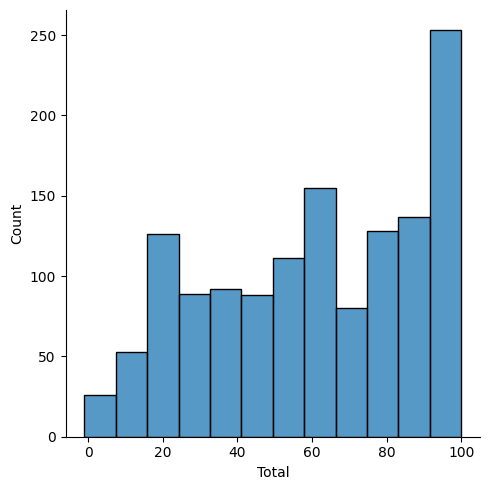

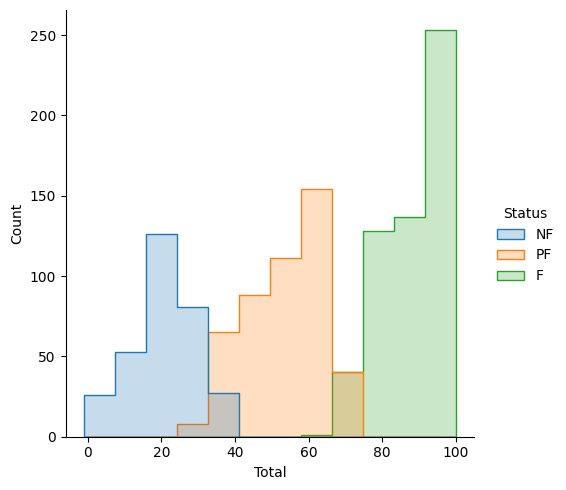

In [4]:
# distribution of the total
sns.displot(freedom_cleaned, x="Total") #left asymmetry

# distributions of the total (political and civil rights) colored according to the status Free, Partially Free, Non Free
sns.displot(freedom_cleaned, x="Total", hue="Status", element="step")

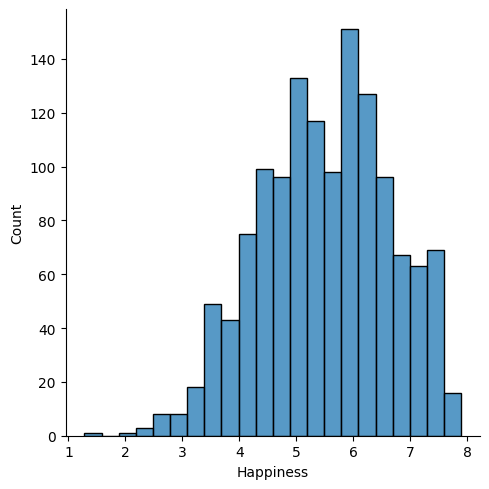

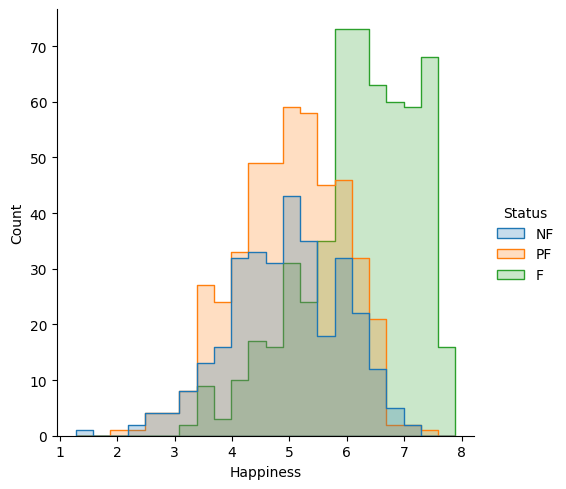

In [5]:

# distribution of the Happiness score
sns.displot(freedom_cleaned, x="Happiness") # left skew

# distribution of the Happiness score based on the Status
sns.displot(freedom_cleaned, x="Happiness", hue='Status', element="step")

**Normalized histogram statistics**

Before we do, another point to note is that, when the subsets have unequal numbers of observations, comparing their distributions in terms of counts may not be ideal. One solution is to normalize the counts using the stat parameter

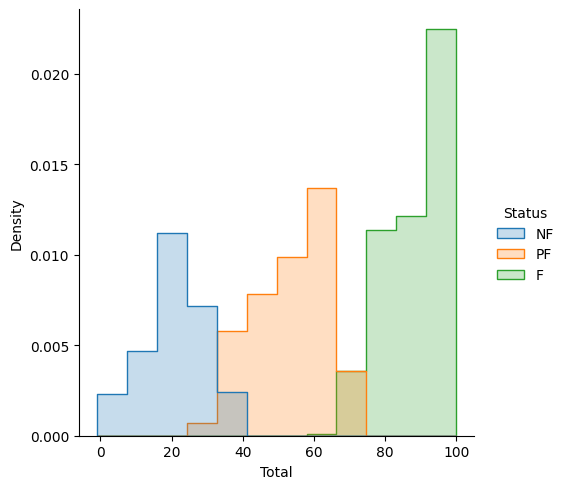

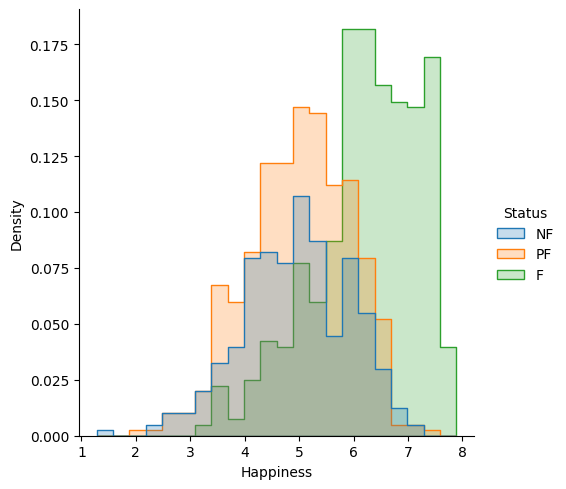

In [6]:
sns.displot(freedom_cleaned, x="Total", hue="Status", element="step", stat="density")

sns.displot(freedom_cleaned, x="Happiness", hue="Status", element="step", stat="density")



**Kernel density estimation**
A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations. Kernel density estimation (KDE) presents a different solution to the same problem. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate:

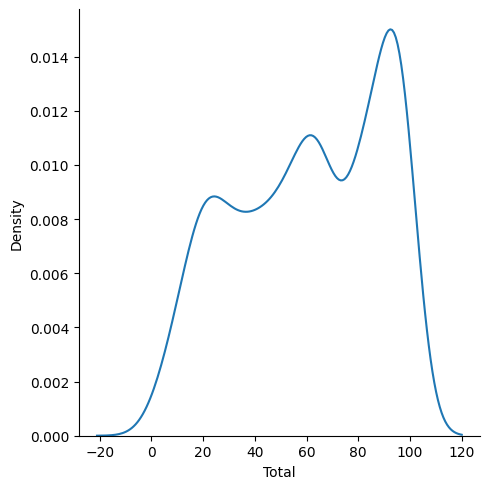

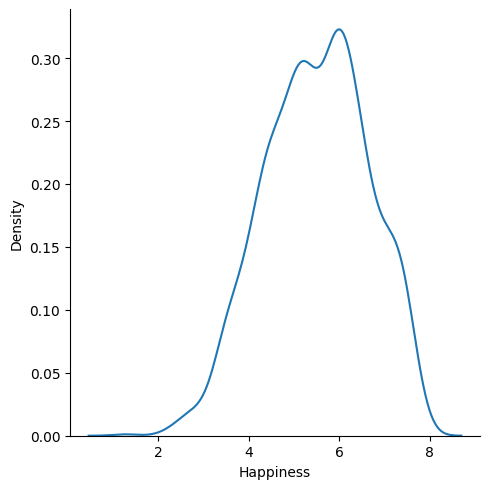

In [7]:
# clearly we see three peaks in Total, while in Happiness only two
# indicator of the presence of sub population
# in Happiness we don't see three peaks because one is hidden from the others (it could have a low weight...)

sns.displot(freedom_cleaned, x="Total", kind="kde")
sns.displot(freedom_cleaned, x="Happiness", kind="kde")


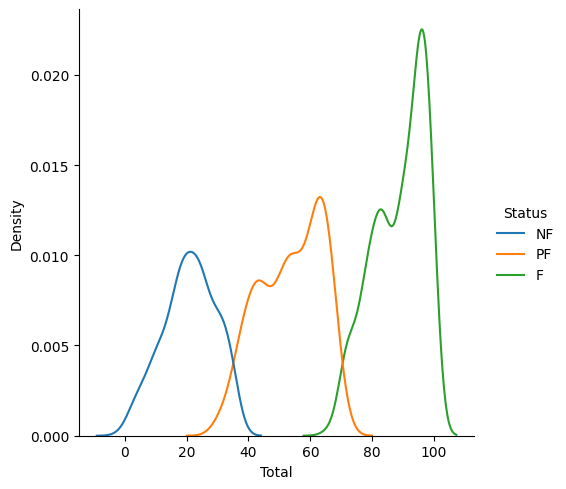

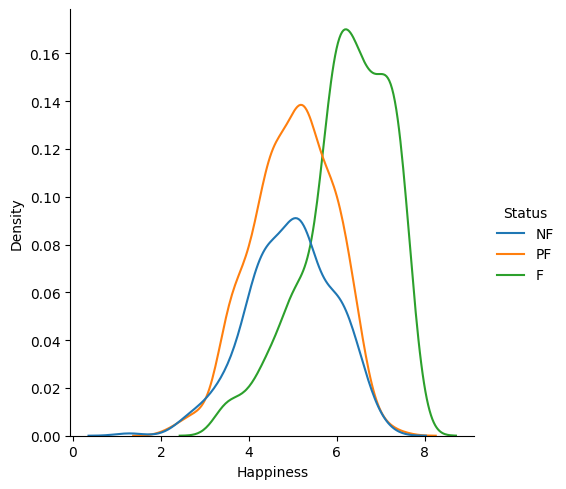

In [8]:
# clear evidence of the three densities
sns.displot(freedom_cleaned, x="Total", hue='Status', kind="kde")
sns.displot(freedom_cleaned, x="Happiness", hue='Status',kind="kde")

# **Mixture Models**



## Freedom 2013


In [9]:
# filter year 2013 from the dataset so that only data from that year is captured
f_2013 = freedom_cleaned[freedom_cleaned['Edition']==2013]
f_2013.info()
f_2013.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 1328
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country name                               135 non-null    object 
 1   Region                                     135 non-null    object 
 2   C/T                                        135 non-null    object 
 3   Edition                                    135 non-null    int64  
 4   Status                                     135 non-null    object 
 5   PR rating                                  135 non-null    int64  
 6   CL rating                                  135 non-null    int64  
 7   A1                                         135 non-null    int64  
 8   A2                                         135 non-null    int64  
 9   A3                                         135 non-null    int64  
 10  A                        

Country name       0
Region             0
C/T                0
Edition            0
Status             0
                  ..
iso_3166-2         1
region             1
sub-region         1
region-code        1
sub-region-code    1
Length: 76, dtype: int64

In [10]:

#delete all rows with a missing value
f_2013.dropna(axis=0, how= 'any', inplace=True)

<ipython-input-10-f489326e68e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_2013.dropna(axis=0, how= 'any', inplace=True)


In [11]:
# select the columns of interest relating to the components of the Freedom
# I also select the name of the country that I set as index
f_2013_freedom = f_2013[['Country name', 'PR', 'CL', 'Total', 'Status']]
f_2013_freedom.reset_index(inplace=True)

f_2013_subset=f_2013[['Country name', 'PR', 'CL' ]]
f_2013_subset.set_index('Country name', inplace=True)

In [12]:

# let's normalize data
f_2013_subset = normalize(f_2013_subset)

# Converting the numpy array into a pandas DataFrame
f_2013_subset = pd.DataFrame(f_2013_subset)


In [13]:
#We rename the normalized columns indexed with 0 and 1 with PR and CL, for greater clarity
f_2013_subset.rename(columns = {0:'PR', 1:'CL'}, inplace = True)
f_2013_subset



,PR,CL
0,0.566529,0.824042
1,0.524097,0.851658
2,0.501036,0.865426
3,0.534642,0.845079
4,0.409056,0.912509
...,...,...
123,0.529999,0.847998
124,0.116841,0.993151
125,0.490261,0.871576
126,0.635707,0.771930


In [14]:
num_col = ['PR', 'CL']
scaler = StandardScaler()
for i in num_col:
  f_2013_subset[[i]] = scaler.fit_transform(f_2013_subset[[i]])


In [15]:

# summary statistics for the transformed data
f_2013_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PR,128.0,-6.938894e-17,1.003929,-5.663846,-0.132016,0.263426,0.501659,1.229378
CL,128.0,-2.428613e-17,1.003929,-1.901821,-0.563278,-0.188399,0.374476,2.957102


In [16]:
# covariance matrix
f_2013_subset.cov()


,PR,CL
PR,1.007874,-0.938190
CL,-0.938190,1.007874


In [17]:
# correlation matrix
f_2013_subset.corr()

,PR,CL
PR,1.00000,-0.93086
CL,-0.93086,1.00000


Text(0, 0.5, 'Score')

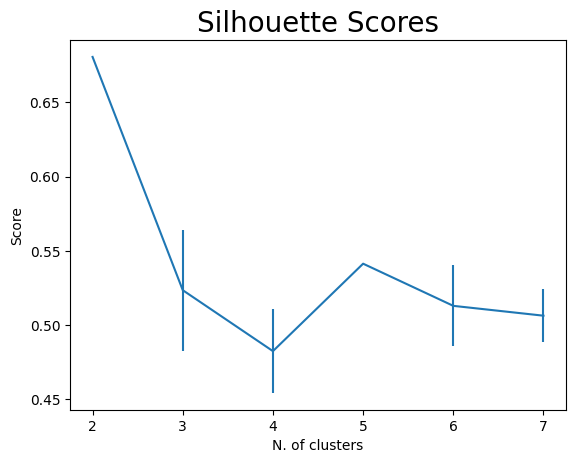

In [18]:
# Calculation of the silhouette coefficient (internal validation, indicates how cohesive the data is)
# we note that the peak is in correspondence of three clusters, it falls from 3 to 6
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gm=GaussianMixture(n, n_init=2, covariance_type='diag', init_params='kmeans' ).fit(f_2013_subset)
        labels=gm.predict(f_2013_subset)
        sil=metrics.silhouette_score(f_2013_subset, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

#Number of components(k) selection:
# Silhouette score checks how much the clusters are compact and well separated.
# The more the score is near to one, the better the clustering is.
# Since we already know that the fitting procedure is not deterministic,
# we run twenty fits for each number of clusters, then we consider the mean value and the standard deviation of the best five runs.

# Silhouette Scores reflect that the best number of clusters is 3: we will see later if also AIC and BIC indices confirm this suggestion.

In [19]:
# Python equivalent of mclust is GaussianMixture from sklearn.mixture
# we develop a GMM with 5 clusters with a diagonal var-cov matrix, i.e. it is single for each cluster
# fixed the various thresholds and set as initialization of the parameters those obtained with kmeans ++, the seed is 123
# fit the model on 2013 data
gm = GaussianMixture(n_components=5,
                     covariance_type='diag',
                     tol=0.0001,
                     reg_covar=1e-06,
                     max_iter=100,
                     n_init=50,
                     init_params='kmeans',
                     weights_init=None,
                     means_init=None,
                     precisions_init=None,
                     random_state=123,
                     warm_start=False,
                     verbose=0,
                     verbose_interval=10).fit(f_2013_subset)


gm.get_params()

{'covariance_type': 'diag',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 5,
 'n_init': 50,
 'precisions_init': None,
 'random_state': 123,
 'reg_covar': 1e-06,
 'tol': 0.0001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [20]:

# observe the centroids of each diagonal cluster

centers = gm.means_
print(centers)

[[ 0.34613002 -0.31824681]
 [-1.15823887  1.47616088]
 [ 0.82972441 -1.13691527]
 [-0.05406968  0.26531805]
 [-4.44490113  2.83102287]]


In [21]:
# We predict labels
# check that there are no empty clusters
# for each unit the probability of belonging to all clusters is calculated
# the cluster is chosen where the probability is maximized
pred = gm.predict(f_2013_subset)
pred


array([0, 3, 3, 3, 1, 0, 0, 1, 1, 2, 1, 0, 3, 2, 0, 0, 3, 0, 0, 1, 1, 1,
       0, 1, 0, 2, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 1, 0,
       0, 2, 0, 0, 3, 2, 1, 0, 0, 2, 2, 3, 2, 0, 2, 0, 2, 0, 1, 1, 3, 3,
       0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 3, 3, 1, 2, 0, 0, 1, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2, 3, 2, 3, 0, 0, 0, 0, 0, 3, 0,
       4, 1, 0, 0, 0, 2, 2, 1, 3, 0, 0, 0, 4, 3, 4, 3, 2, 2])

In [22]:
# probability of unit i belonging to cluster j (the probability of belonging to all clusters is calculated for each unit)
# assignment to a cluster follows the principle of probability maximization
probs = gm.predict_proba(f_2013_subset)


In [23]:

# I sort the clusters in ascending order, for greater clarity
# cluster 4--> 0: least free countries
# cluster 1--> 1
# cluster 3 --> 2
# cluster 2--> 3
#clsuetr 0 --> 4
cluster_array = np.array([0, 3, 3, 3, 1, 0, 0, 1, 1, 2, 1, 0, 3, 2, 0, 0, 3, 0, 0, 1, 1, 1,
       0, 1, 0, 2, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 1, 0,
       0, 2, 0, 0, 3, 2, 1, 0, 0, 2, 2, 3, 2, 0, 2, 0, 2, 0, 1, 1, 3, 3,
       0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 3, 3, 1, 2, 0, 0, 1, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2, 3, 2, 3, 0, 0, 0, 0, 0, 3, 0,
       4, 1, 0, 0, 0, 2, 2, 1, 3, 0, 0, 0, 4, 3, 4, 3, 2, 2])
remapped_clusters = np.where(cluster_array == 4, 0,
                             np.where(cluster_array == 1, 1,
                                      np.where(cluster_array == 3, 2,
                                               np.where(cluster_array == 2, 3, 4))))

print(remapped_clusters)


[4 2 2 2 1 4 4 1 1 3 1 4 2 3 4 4 2 4 4 1 1 1 4 1 4 3 1 3 4 2 4 4 4 4 4 4 2
 3 4 2 4 4 1 4 4 3 4 4 2 3 1 4 4 3 3 2 3 4 3 4 3 4 1 1 2 2 4 1 4 4 1 3 4 1
 4 1 3 3 4 2 2 1 3 4 4 1 3 3 4 3 3 3 4 4 4 4 4 1 1 3 2 3 2 4 4 4 4 4 2 4 0
 1 4 4 4 3 3 1 2 4 4 4 0 2 0 2 3 3]


In [24]:
f_2013_subset['Cluster']=remapped_clusters

#f_2013_subset.reset_index(inplace=True)
f_2013_subset['Political Rights']= f_2013_freedom['PR']
f_2013_subset['Civil Rights']= f_2013_freedom['CL']
f_2013_subset['Total Freedom']= f_2013_freedom['Total']
f_2013_subset['Country name'] = f_2013_freedom['Country name']


In [25]:
# create the scatterplot of sorted and remapped clusters

fig = px.scatter(f_2013_subset, x=f_2013_subset['PR'], y=f_2013_subset['CL'], hover_data=f_2013_subset[['Political Rights','Civil Rights','Country name', 'Total Freedom','Cluster']], color="Cluster")


fig.update_layout(
    title='Freedom 2013 Clustering',
    xaxis_title='Politics Rights',
    yaxis_title='Civil Rights'
)


fig.show()

Features we note:
from the scatterplot we note that the cluster 0-1 and 3-4 are well cohesive with each other and well separated: they indicate countries in diametrically opposite situations.
cluster 2 instead appears to be the most scattered.

In [26]:
# coropleth map dei clusters
fig = go.Figure(
    go.Choropleth(
        locations=f_2013_subset["Country name"],
        z=f_2013_subset['Cluster'],
        locationmode='country names',
        colorscale='armyrose',
        autocolorscale=False,
        marker_line_color="white",
        marker_line_width=0.5,
        colorbar=dict(
            tickvals=[0, 1, 2, 3, 4],
            ticktext=["0", "1", "2", "3", "4"]
        )
    )
)
fig.show()

In [27]:
# Eliminate the columns not used to pull the model to calculate the silhouette coefficient
f_2013_subset.drop(['Cluster', 'Political Rights', 'Civil Rights', 'Total Freedom', 'Country name'], axis=1, inplace=True)
f_2013_subset


,PR,CL
0,0.333425,-0.295628
1,-0.014725,0.214883
2,-0.203942,0.469396
3,0.071791,0.093256
4,-0.958642,1.339764
...,...,...
123,0.033697,0.147225
124,-3.356267,2.830485
125,-0.292351,0.583070
126,0.901035,-1.258956


In [28]:

# INTERNAL validation indices
# are based on the concept of distance and similarity within a cluster
# do not require external information such as a known partition

# silhouette coefficient: [-1,+1], how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
#The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters

data_subset = f_2013_subset[['PR','CL']]
silhouette = silhouette_score(data_subset, remapped_clusters)
print(f'Silhouette Score: {silhouette}')



# calinski_harabasz: ratio of the sum of inter-cluster dispersion and the sum of intra-cluster dispersion for all clusters
# (where the dispersion is the sum of squared distances). Higher values mean good clustering.

calinski_harabasz= metrics.calinski_harabasz_score(data_subset, remapped_clusters)
print(f'Calinski Harabasz Score: {calinski_harabasz}')


# davies bouldin: Due to the way it is defined, as a function of the ratio of the within cluster scatter, to the between cluster separation,
#a lower value will mean that the clustering is better. It is a symmetric and non negative index

davies_bouldin = davies_bouldin_score(data_subset, remapped_clusters)
print(f'Davies Bouldin Score: {davies_bouldin}')

Silhouette Score: 0.5414228413530993
Calinski Harabasz Score: 312.93142127867196
Davies Bouldin Score: 0.48511892387028394


In [29]:
# Aic and Bic to determine the best fit
n_c = [2, 3, 4, 5, 6, 7]
aic = []
bic = []

for i in n_c:
  gm = GaussianMixture(n_components=i, random_state=123, covariance_type='diag', init_params='kmeans')
  gm.fit(data_subset)
  aic.append(round(gm.aic(data_subset)))
  bic.append(round(gm.bic(data_subset)))

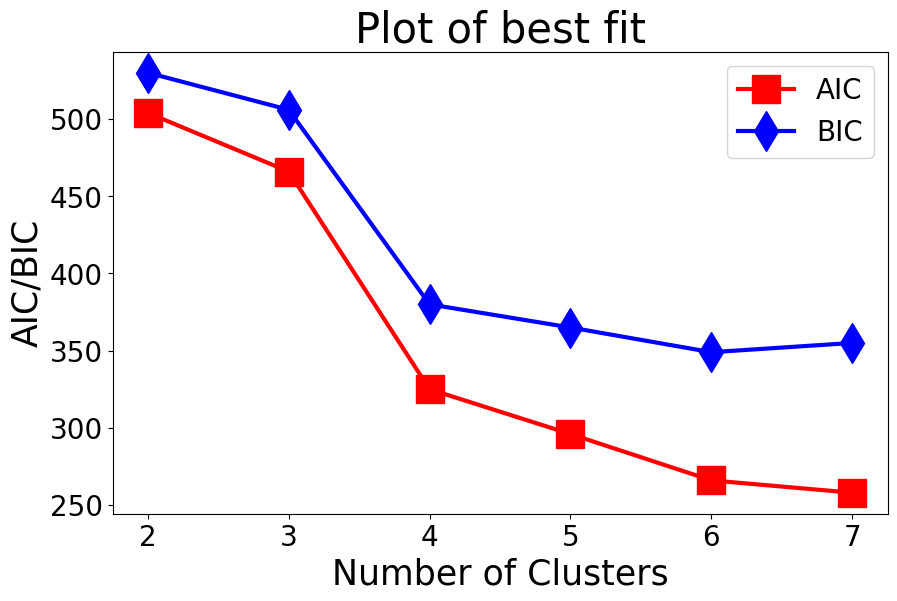

In [30]:
plt.figure(figsize=(10,6))
plt.plot(n_c, aic, color='r', linewidth=3, marker='s', markersize=20, label='AIC')
plt.plot(n_c, bic, color='b', linewidth=3, marker='d', markersize=20, label='BIC')
plt.ylabel('AIC/BIC', fontsize=25)
plt.xlabel('Number of Clusters', fontsize=25)
plt.title('Plot of best fit', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [31]:
print(aic)
print(bic)

[504, 466, 325, 296, 266, 258]
[530, 506, 380, 365, 349, 355]



The AIC and BIC study recommend using 7 clusters instead of 5: therefore we retrain the model using 7 clusters.

In [32]:


f_2013_subset


,PR,CL
0,0.333425,-0.295628
1,-0.014725,0.214883
2,-0.203942,0.469396
3,0.071791,0.093256
4,-0.958642,1.339764
...,...,...
123,0.033697,0.147225
124,-3.356267,2.830485
125,-0.292351,0.583070
126,0.901035,-1.258956


In [33]:

# fit the model with 3 clusters on 2013 data
gm_3 = GaussianMixture(n_components=3,
                     covariance_type='diag',
                     tol=0.0001,
                     reg_covar=1e-06,
                     max_iter=100,
                     n_init=50,
                     init_params='kmeans',
                     weights_init=None,
                     means_init=None,
                     precisions_init=None,
                     random_state=123,
                     warm_start=False,
                     verbose=0,
                     verbose_interval=10).fit(f_2013_subset)


pred_3 = gm_3.predict(f_2013_subset)
pred_3


array([0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2])

In [34]:
probs = gm_3.predict_proba(f_2013_subset)

In [35]:


# I sort the clusters in ascending order
# cluster 1--> 0: least free countries
# clusters 2--> 1
# clusters 0 --> 2

cluster_array = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2])
remapped_clusters = np.where(cluster_array == 1, 0,
                                np.where(cluster_array == 2, 1,
                                         np.where(cluster_array == 0, 2, 2)))

print(remapped_clusters)



[2 2 0 2 0 2 2 0 0 1 0 2 2 1 2 2 2 2 2 0 0 0 2 0 2 1 0 1 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 0 2 2 1 2 2 2 1 0 2 2 1 1 0 1 2 1 2 1 2 0 0 2 0 2 0 2 2 0 1 2 0
 2 0 1 1 2 0 0 0 2 2 2 0 1 1 2 1 1 1 2 2 2 2 2 0 0 2 2 1 0 2 2 2 2 2 0 2 0
 0 2 2 2 1 1 0 0 2 2 2 0 2 0 0 1 1]


In [36]:
f_2013_subset['Cluster']=remapped_clusters

f_2013_subset.reset_index(inplace=True)
f_2013_subset['Country name']= f_2013_freedom['Country name']
f_2013_subset['Political Rights']= f_2013_freedom['PR']
f_2013_subset['Civil Rights']= f_2013_freedom['CL']
f_2013_subset['Total Freedom']= f_2013_freedom['Total']


fig = px.scatter(f_2013_subset, x=f_2013_subset['PR'], y=f_2013_subset['CL'], hover_data=f_2013_subset[['Political Rights','Civil Rights','Country name', 'Total Freedom','Cluster']], color="Cluster")


fig.update_layout(
    title='Freedom 2013 Clustering',
    xaxis_title='Politics Rights',
    yaxis_title='Civil Rights'
)


fig.show()

Coesione migliorata rispetto a prima, cluster 1 e 2 ben coesi, cluster 0 sparso

In [37]:
# internal evaluation measures
data_subset = f_2013_subset[['PR', 'CL']]
silhouette = silhouette_score(data_subset, remapped_clusters)
print(f'Silhouette Score: {silhouette}') # [-1,+1], valori alti indicano buona clusterizzazione


calinski_harabasz= metrics.calinski_harabasz_score(data_subset, remapped_clusters)
print(f'Calinski Harabasz Score: {calinski_harabasz}') #Higher values mean good clustering.

davies_bouldin = davies_bouldin_score(data_subset, remapped_clusters)
print(f'Davies Bouldin Score: {davies_bouldin}') #smaller values mean good clustering

Silhouette Score: 0.5256847948021395
Calinski Harabasz Score: 136.83397099458043
Davies Bouldin Score: 0.5644802631963262


In [38]:
# EXTERNAL EVALUATION
# for evaluation with external indexes we need to compare our data with a known partition
# in our case the known partition is that of Free, Non free and Partially free countries.
freedom_dict = {0:'NF',
                1:'PF',
                2:'F'
                }

f_2013_subset['Predicted_Label'] = f_2013_subset['Cluster'].map(freedom_dict)
f_2013_subset['Actual_Label'] = f_2013_freedom['Status']
f_2013_subset

,index,PR,CL,Cluster,Country name,Political Rights,Civil Rights,Total Freedom,Predicted_Label,Actual_Label
0,0,0.333425,-0.295628,2,Afghanistan,11,16,27,F,NF
1,1,-0.014725,0.214883,2,Albania,24,39,63,F,PF
2,2,-0.203942,0.469396,0,Angola,11,19,30,NF,NF
3,3,0.071791,0.093256,2,Argentina,31,49,80,F,F
4,4,-0.958642,1.339764,0,Armenia,13,29,42,NF,PF
...,...,...,...,...,...,...,...,...,...,...
123,123,0.033697,0.147225,2,Venezuela,15,24,39,F,PF
124,124,-3.356267,2.830485,0,Vietnam,2,17,19,NF,NF
125,125,-0.292351,0.583070,0,Yemen,9,16,25,NF,NF
126,126,0.901035,-1.258956,1,Zambia,28,34,62,PF,PF


In [39]:
# external evaluation
labels_true = f_2013_subset['Actual_Label']
labels_pred = f_2013_subset['Predicted_Label']

# a measure of the similarity between two data clusterings
# range [-1,+1],
#where 1 indicates perfect agreement between the two clusterings,
#0 indicates a random agreement and
#-1 indicates that the two clusterings are completely different.
adjusted_rand = metrics.adjusted_rand_score(labels_true, labels_pred)
print(f'Adjusted Rand Score: {adjusted_rand}')

# range [0,1], 1.0 stands for perfectly homogeneous labeling
homogeneity = metrics.homogeneity_score(labels_true, labels_pred)
print(f'Homogeneity: {homogeneity}')

# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster
#range [0,1], 1.0 stands for perfectly labeling
completeness = metrics.completeness_score(labels_true, labels_pred)
print(f'Completeness: {completeness}')


#Fowlkes-Mallows index (FMI) is defined as the geometric mean between of the precision and recall
# The score ranges from 0 to 1. A high value indicates a good similarity between two clusters
f_m = metrics.fowlkes_mallows_score(labels_true, labels_pred)
print(f'Fowlkes Mallows Score: {f_m}')

Adjusted Rand Score: 0.3134465282321989
Homogeneity: 0.28145128826526494
Completeness: 0.2936714433473
Fowlkes Mallows Score: 0.5702828820585333


In [40]:
precision = precision_score(labels_true, labels_pred, average='weighted')
print(f'Precision: {precision}')


recall = recall_score(labels_true, labels_pred, average='weighted')
print(f'Recall: {recall}')

accuracy = accuracy_score(labels_true, labels_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(labels_true, labels_pred, average='weighted')
print(f'F1 Score: {f1}')


Precision: 0.6472308298319328
Recall: 0.6640625
Accuracy: 0.6640625
F1 Score: 0.6404553420830698


Coropleth dei clusters

In [41]:
# 3 clusters
fig = go.Figure(
    go.Choropleth(
        locations=f_2013_subset["Country name"],  # Locations
        z=f_2013_subset['Cluster'],
        locationmode='country names',
        colorscale= 'matter',
        autocolorscale=False,
        marker_line_color="white",
        marker_line_width=0.5,
        colorbar=dict(
            tickvals=[0, 1, 2],
            ticktext=["0", "1", "2"]
        ),
        )
    )
fig.show()

## Freedom 2022



Cluster data from the year 2022, based on the model extracted in 2013

In [42]:
f_2022 = freedom_cleaned[freedom_cleaned['Edition']==2022]
f_2022.info()
f_2022.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 8 to 1337
Data columns (total 76 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country name                               113 non-null    object 
 1   Region                                     113 non-null    object 
 2   C/T                                        113 non-null    object 
 3   Edition                                    113 non-null    int64  
 4   Status                                     113 non-null    object 
 5   PR rating                                  113 non-null    int64  
 6   CL rating                                  113 non-null    int64  
 7   A1                                         113 non-null    int64  
 8   A2                                         113 non-null    int64  
 9   A3                                         113 non-null    int64  
 10  A                        

Country name       0
Region             0
C/T                0
Edition            0
Status             0
                  ..
iso_3166-2         1
region             1
sub-region         1
region-code        1
sub-region-code    1
Length: 76, dtype: int64

In [43]:
# for simplicity we delete all lines with a missing value
f_2022.dropna(axis=0, how= 'any', inplace=True)

<ipython-input-43-fec00c52b4ca>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
# select the columns of interest relating to the components of the Freedom
# I also select the name of the country that I set as index
f_2022_freedom = f_2022[['Country name', 'PR', 'CL', 'Total', 'Status']]
f_2022_freedom.reset_index(inplace=True)

f_2022_subset=f_2022[['Country name', 'PR', 'CL' ]]
f_2022_subset.set_index('Country name', inplace=True)

In [45]:
# Normalizing Data
f_2022_subset = normalize(f_2022_subset)

# Converting the numpy array into a pandas DataFrame
f_2022_subset = pd.DataFrame(f_2022_subset)

In [46]:
f_2022_subset.rename(columns = {0:'PR', 1:'CL'}, inplace = True)
f_2022_subset



,PR,CL
0,0.110432,0.993884
1,0.583207,0.812324
2,0.581238,0.813733
3,0.583636,0.812015
4,0.571494,0.820606
...,...,...
96,0.596324,0.802744
97,0.585491,0.810679
98,0.531491,0.847064
99,0.574426,0.818557


In [47]:
# standardizing data

num_col = ['PR', 'CL']
scaler = StandardScaler()
for i in num_col:
  f_2022_subset[[i]] = scaler.fit_transform(f_2022_subset[[i]])


In [48]:
# descriptive statistics of our data
f_2022_subset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PR,101.0,7.615608e-16,1.004988,-4.132668,0.019630,0.264517,0.486874,1.747522
CL,101.0,2.744917e-15,1.004988,-2.754546,-0.498362,-0.181919,0.143428,2.896546


In [49]:
# covariance matrix

print(f_2022_subset.cov())

print(f_2022_subset.corr())




         PR       CL
PR  1.01000 -0.97711
CL -0.97711  1.01000
          PR        CL
PR  1.000000 -0.967436
CL -0.967436  1.000000


In [50]:
# predictions on 3 clusters
pred_2022 = gm_3.predict(f_2022_subset)

pred_2022



array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2,
       1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2,
       2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0])

In [51]:
#ordering clusters
# cluster 1--> 0: not free countries
# cluster 2--> 1
# cluster 0--> 2

cluster_array = np.array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2,
       1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0, 0, 2,
       2, 0, 1, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0])
remapped_clusters_2 = np.where(cluster_array == 1, 0,
                                np.where(cluster_array == 2, 1,
                                         np.where(cluster_array == 0, 2, 2)))

print(remapped_clusters_2)



[0 2 2 2 2 2 2 2 0 2 2 2 2 0 2 0 2 1 0 0 2 2 2 2 2 2 2 1 0 1 2 0 2 2 0 2 1
 2 2 0 1 0 2 1 0 0 2 1 2 2 2 0 0 2 2 0 1 2 2 1 1 0 2 2 2 1 1 2 0 0 2 1 2 2
 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 2 2 2 2 2 2]


In [52]:
f_2022_subset.reset_index(level=0, inplace=True)


In [53]:
f_2022_subset['Cluster']=remapped_clusters_2
f_2022_subset['Political Rights']= f_2022_freedom['PR']
f_2022_subset['Civil Rights']= f_2022_freedom['CL']
f_2022_subset['Total Freedom']= f_2022_freedom['Total']
f_2022_subset['Country name']=f_2022_freedom['Country name']


In [54]:
fig = px.scatter(f_2022_subset, x=f_2022_subset['PR'], y=f_2022_subset['CL'], hover_data=f_2022_subset[['Political Rights','Civil Rights','Country name', 'Total Freedom','Cluster']], color="Cluster")


fig.update_layout(
    title='Freedom 2022 Clustering',
    xaxis_title='Politics Rights',
    yaxis_title='Civil Rights'
)


fig.show()

In [55]:
# internal measures
data_subset = f_2022_subset[['PR','CL']]
silhouette = silhouette_score(data_subset, remapped_clusters_2)
print(f'Silhouette Score: {silhouette}')


calinski_harabasz= metrics.calinski_harabasz_score(data_subset, remapped_clusters_2)
print(f'Calinski Harabasz Score: {calinski_harabasz}') #The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)


davies_bouldin = davies_bouldin_score(data_subset, remapped_clusters_2)
print(f'Davies Bouldin Score: {davies_bouldin}') #lower Davies-Bouldin index relates to a model with better separation between the clusters. (N.B: The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCA)

Silhouette Score: 0.47112356733314414
Calinski Harabasz Score: 50.211456082099396
Davies Bouldin Score: 0.7659084092547598


**_External measures_**


In [56]:
freedom_dict = {0:'NF',
                1:'PF',
                2:'F'
                }

f_2022_subset['Predicted_Label'] = f_2022_subset['Cluster'].map(freedom_dict)
f_2022_subset['Actual_Label'] = f_2022_freedom['Status']
f_2022_subset

,index,PR,CL,Cluster,Political Rights,Civil Rights,Total Freedom,Country name,Predicted_Label,Actual_Label
0,0,-3.786656,2.833754,0,1,9,10,Afghanistan,NF,NF
1,1,0.388113,-0.355253,2,28,39,67,Albania,F,PF
2,2,0.370730,-0.330492,2,35,49,84,Argentina,F,F
3,3,0.391904,-0.360670,2,23,32,55,Armenia,F,PF
4,4,0.284683,-0.209772,2,39,56,95,Australia,F,F
...,...,...,...,...,...,...,...,...,...,...
96,96,0.503943,-0.523519,2,26,35,61,Ukraine,F,PF
97,97,0.408280,-0.384138,2,39,54,93,United Kingdom,F,F
98,98,-0.068554,0.254939,2,32,51,83,United States,F,F
99,99,0.310574,-0.245775,2,40,57,97,Uruguay,F,F


In [57]:
# external evaluation
# RAND index The score range is [-1, 1] for the adjusted Rand index.
labels_true = f_2022_subset['Actual_Label']
labels_pred = f_2022_subset['Predicted_Label']

adjusted_rand = metrics.adjusted_rand_score(labels_true, labels_pred)
print(f'Adjusted Rand Score: {adjusted_rand}')


homogeneity = metrics.homogeneity_score(labels_true, labels_pred)
print(f'Homogeneity: {homogeneity}')

completeness = metrics.completeness_score(labels_true, labels_pred)
print(f'Completeness: {completeness}')

f_m = metrics.fowlkes_mallows_score(labels_true, labels_pred)
print(f'Fowlkes Mallows Score: {f_m}') #The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

Adjusted Rand Score: 0.379986781529224
Homogeneity: 0.3729247578502392
Completeness: 0.4036182015586358
Fowlkes Mallows Score: 0.6438688575183539


In [58]:
precision = precision_score(labels_true, labels_pred, average='weighted')
print(f'Precision: {precision}')


recall = recall_score(labels_true, labels_pred, average='weighted')
print(f'Recall: {recall}')

accuracy = accuracy_score(labels_true, labels_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(labels_true, labels_pred, average='weighted')
print(f'F1 Score: {f1}')


Precision: 0.7407389186123582
Recall: 0.7128712871287128
Accuracy: 0.7128712871287128
F1 Score: 0.6782938739479526


In [59]:
fig = go.Figure(
    go.Choropleth(
        locations=f_2022_subset["Country name"],
        z=f_2022_subset['Cluster'],
        locationmode='country names',
        colorscale= 'ice',
        autocolorscale=False,
        marker_line_color="white",
        marker_line_width=0.5,
        colorbar=dict(
            tickvals=[0, 1, 2],
            ticktext=["0", "1", "2"]
        ),
        )
    )
fig.show()

## Differences 2013-2022

In [60]:
f_2013_final=f_2013_subset[['Country name', 'Political Rights', 'Civil Rights', 'Total Freedom', 'Cluster']]
f_2022_final=f_2022_subset[['Country name', 'Political Rights', 'Civil Rights', 'Total Freedom', 'Cluster']]

In [61]:
merged_2013_2022=f_2013_final.merge(f_2022_final, how='inner', on=['Country name'], suffixes= ['_2013', '_2022'])
merged_2013_2022

,Country name,Political Rights_2013,Civil Rights_2013,Total Freedom_2013,Cluster_2013,Political Rights_2022,Civil Rights_2022,Total Freedom_2022,Cluster_2022
0,Afghanistan,11,16,27,2,1,9,10,0
1,Albania,24,39,63,2,28,39,67,2
2,Argentina,31,49,80,2,35,49,84,2
3,Armenia,13,29,42,0,23,32,55,2
4,Australia,39,58,97,2,39,56,95,2
...,...,...,...,...,...,...,...,...,...
87,Ukraine,21,36,57,0,26,35,61,2
88,United Kingdom,40,57,97,2,39,54,93,2
89,United States,37,56,93,2,32,51,83,2
90,Uruguay,39,58,97,2,40,57,97,2


In [62]:
merged_2013_2022['Difference']= merged_2013_2022['Cluster_2022']-merged_2013_2022['Cluster_2013']

In [63]:
colorscale = [[0, 'red'], [0.5, 'white'], [1, 'blue']]
fig = go.Figure(
    go.Choropleth(
        locations=merged_2013_2022["Country name"],
        z=merged_2013_2022['Difference'],
        locationmode='country names',
        colorscale=colorscale,
        autocolorscale=False,
        marker_line_color="white",
        marker_line_width=0.5,
        colorbar=dict(
            tickvals=[-2, -1, 0, 1, 2],
            ticktext=["-2","-1","0", "1", "2"]
        ),
        )
    )
fig.show()

In [64]:
merged_2013_2022[merged_2013_2022["Country name"]=='Afghanistan']
#merged_2013_2022[merged_2013_2022["Cluster_2022"]==1]

,Country name,Political Rights_2013,Civil Rights_2013,Total Freedom_2013,Cluster_2013,Political Rights_2022,Civil Rights_2022,Total Freedom_2022,Cluster_2022,Difference
0,Afghanistan,11,16,27,2,1,9,10,0,-2


In [65]:
merged_2013_2022[merged_2013_2022["Difference"]==0]

,Country name,Political Rights_2013,Civil Rights_2013,Total Freedom_2013,Cluster_2013,Political Rights_2022,Civil Rights_2022,Total Freedom_2022,Cluster_2022,Difference
1,Albania,24,39,63,2,28,39,67,2,0
2,Argentina,31,49,80,2,35,49,84,2,0
4,Australia,39,58,97,2,39,56,95,2,0
5,Austria,38,58,96,2,37,56,93,2,0
7,Belgium,40,57,97,2,39,57,96,2,0
...,...,...,...,...,...,...,...,...,...,...
82,Spain,39,57,96,2,37,53,90,2,0
83,Sweden,40,60,100,2,40,60,100,2,0
88,United Kingdom,40,57,97,2,39,54,93,2,0
89,United States,37,56,93,2,32,51,83,2,0


In [66]:
merged_2013_2022[merged_2013_2022["Difference"]!=0]

,Country name,Political Rights_2013,Civil Rights_2013,Total Freedom_2013,Cluster_2013,Political Rights_2022,Civil Rights_2022,Total Freedom_2022,Cluster_2022,Difference
0,Afghanistan,11,16,27,2,1,9,10,0,-2
3,Armenia,13,29,42,0,23,32,55,2,2
6,Bangladesh,25,31,56,1,15,24,39,2,1
8,Benin,32,50,82,2,17,42,59,0,-2
18,Congo (Kinshasa),9,11,20,1,4,15,19,0,-1
26,Ecuador,24,36,60,2,31,40,71,1,-1
27,Egypt,16,25,41,2,6,12,18,0,-2
30,Ethiopia,7,11,18,2,12,11,23,0,-2
33,Georgia,24,36,60,2,22,36,58,0,-2
38,Guinea,15,24,39,2,10,24,34,0,-2


## Cambiamento percentuale

Calcolo la media del cambiamento percentuale degli anni nel dataset, escludento il primo (2013) e l'ultimo (2022)

In [67]:
# seleziono tutte le edizioni eccetto primaa e ultima
freedom_intermediate = freedom_cleaned[(freedom_cleaned['Edition']!=2013)&(freedom_cleaned['Edition']!=2022)]
freedom_intermediate.reset_index(inplace=True)
freedom_intermediate.drop('index', axis=1, inplace=True)
freedom_intermediate

<ipython-input-67-9b6f2e9ee81d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country name,Region,C/T,Edition,Status,PR rating,CL rating,A1,A2,A3,...,Perceptions of corruption % change,Positive affect,Negative affect,Happiness scaled,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
0,Afghanistan,Asia,c,2014,NF,6,6,1,1,1,...,0.003405,0.491641,0.374861,31.308956,4.0,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Afghanistan,Asia,c,2015,NF,6,6,1,1,1,...,0.000116,0.491410,0.339276,39.828546,4.0,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
2,Afghanistan,Asia,c,2016,NF,6,6,1,0,1,...,0.009848,0.501409,0.348332,42.201686,4.0,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
3,Afghanistan,Asia,c,2017,NF,6,6,1,0,1,...,0.041269,0.435270,0.371326,26.617181,4.0,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
4,Afghanistan,Asia,c,2018,NF,5,6,1,0,1,...,0.000788,0.384561,0.404904,26.943033,4.0,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,Zimbabwe,Africa,c,2017,PF,5,5,1,1,1,...,0.001454,0.733641,0.224051,36.383002,716.0,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,2.0,202.0
1086,Zimbabwe,Africa,c,2018,NF,6,5,0,1,1,...,0.015327,0.657524,0.211726,36.164799,716.0,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,2.0,202.0
1087,Zimbabwe,Africa,c,2019,PF,5,5,1,1,1,...,0.000258,0.658434,0.235354,26.935232,716.0,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,2.0,202.0
1088,Zimbabwe,Africa,c,2020,PF,5,5,1,1,1,...,0.002572,0.660658,0.345736,31.598022,716.0,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,2.0,202.0


In [68]:

zmin = -2
zmax = 3
bin_size = 0.05
num_bins = int((zmax - zmin) / bin_size)
years = freedom_intermediate["Edition"].unique()

colorscale = 'Rainbow'

for i in years:

    freedom_year = freedom_intermediate[freedom_intermediate["Edition"] == i]


    bin_limits = np.arange(zmin, zmax + bin_size, bin_size)


    fig = go.Figure(
        go.Choropleth(
            locations=freedom_year["Country name"],
            z=freedom_year["PR % change"],
            locationmode="country names",
            colorscale=colorscale,
            autocolorscale=False,
            marker_line_color="white",
            marker_line_width=0.5,
            zmin=zmin,
            zmax=zmax,
            zmid=(zmin + zmax) / 2,
            colorbar=dict(
                tickmode='array',
                tickvals=[zmin, zmax],
                ticktext=[round(zmin, 2), round(zmax, 2)]
            )
        )
    )


    fig.update_layout(
        title_text=f"Coropleth Map percentual change in Political Rights - Anno {i}",
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type="equirectangular"
        )
    )


    fig.show()


In [69]:

zmin = -2
zmax = 3
bin_size = 0.05
num_bins = int((zmax - zmin) / bin_size)
years = freedom_intermediate["Edition"].unique()

colorscale = 'Jet'

for i in years:

    freedom_year = freedom_intermediate[freedom_intermediate["Edition"] == i]


    bin_limits = np.arange(zmin, zmax + bin_size, bin_size)


    fig = go.Figure(
        go.Choropleth(
            locations=freedom_year["Country name"],
            z=freedom_year["CL % change"],
            locationmode="country names",
            colorscale=colorscale,
            autocolorscale=False,
            marker_line_color="white",
            marker_line_width=0.5,
            zmin=zmin,
            zmax=zmax,
            zmid=(zmin + zmax) / 2,
            colorbar=dict(
                tickmode='array',
                tickvals=[zmin, zmax],
                ticktext=[round(zmin, 2), round(zmax, 2)]
            )
        )
    )


    fig.update_layout(
        title_text=f"Coropleth Map percentual change in Civil Rights - Anno {i}",
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type="equirectangular"
        )
    )


    fig.show()


In [70]:

zmin = -2
zmax = 3
bin_size = 0.05
num_bins = int((zmax - zmin) / bin_size)
years = freedom_intermediate["Edition"].unique()

colorscale = 'Rainbow'

for i in years:

    freedom_year = freedom_intermediate[freedom_intermediate["Edition"] == i]


    bin_limits = np.arange(zmin, zmax + bin_size, bin_size)


    fig = go.Figure(
        go.Choropleth(
            locations=freedom_year["Country name"],
            z=freedom_year["Total % change"],
            locationmode="country names",
            colorscale=colorscale,
            autocolorscale=False,
            marker_line_color="white",
            marker_line_width=0.5,
            zmin=zmin,
            zmax=zmax,
            zmid=(zmin + zmax) / 2,
            colorbar=dict(
                tickmode='array',
                tickvals=[zmin, zmax],
                ticktext=[round(zmin, 2), round(zmax, 2)]
            )
        )
    )


    fig.update_layout(
        title_text=f"Coropleth Map percentual change in Total Freedom - Anno {i}",
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type="equirectangular"
        )
    )


    fig.show()
